In [1]:
from optimum.intel.openvino import OVStableDiffusionPipeline
prompt = "plant pokemon in jungle"#"a drawing of a green pokemon with red eyes"# #"Super cute fluffy cat warrior in armor, photorealistic, 4K, ultra detailed, vray rendering, unreal engine"#"sailing ship in storm by Rembrandt"
# model_id = "runwayml/stable-diffusion-v1-5"
# ov_pipe = OVStableDiffusionPipeline.from_pretrained("/home/alex/work/experimental/stable_diffusion_quantization/ov_pipeline")
# ov_pipe.reshape(batch_size=1, height=512, width=512, num_images_per_prompt=1)
# ov_pipe.compile()
# print("Done")

/home/alex/virt_envs/stable_diffusion/lib/python3.8/site-packages/openvino/offline_transformations/__init__.py:10: FutureWarning: The module is private and following namespace `offline_transformations` will be removed in the future, use `openvino.runtime.passes` instead!
  warnings.warn(


INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, onnx, openvino


In [2]:
# output = ov_pipe(prompt, num_inference_steps=50, output_type="pil")

In [3]:
from IPython.display import Image, display

# display(output.images[0])

In [4]:
q_ov_pipe = OVStableDiffusionPipeline.from_pretrained("/home/alex/work/experimental/stable_diffusion_quantization/sd-model-finetuned/openvino", compile=False) #sd_nncf_ov_alt
q_ov_pipe.reshape(batch_size=1, height=512, width=512, num_images_per_prompt=1)
q_ov_pipe.compile()

print("Done")

The config attributes {'requires_safety_checker': True, 'safety_checker': ['stable_diffusion', 'StableDiffusionSafetyChecker']} were passed to OVStableDiffusionPipeline, but are not expected and will be ignored. Please verify your model_index.json configuration file.
Compiling the encoder and creating the inference request ...
Compiling the encoder and creating the inference request ...
Compiling the encoder and creating the inference request ...


Done


  0%|          | 0/51 [00:00<?, ?it/s]

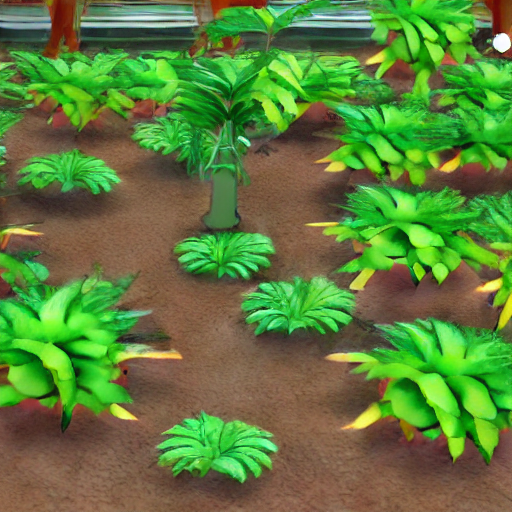

In [10]:
prompt = "Super cute fluffy cat warrior in armor, photorealistic, 4K, ultra detailed, vray rendering, unreal engine"#"plant pokemon in jungle"#"a drawing of a green pokemon with red eyes"#"sailing ship in storm by Rembrandt"#
output = q_ov_pipe(prompt, num_inference_steps=50, output_type="pil")
display(output.images[0])